In [10]:
#Data imports

import pandas as pd

isotherm_cv = pd.read_csv('isotherm_CV_data.csv', index_col=None)

isotherm_cv.head(3)

,Ce_COOH,Qe_COOH,Ce_SH,Qe_SH,Ce_MSN,Qe_MSN
0,0.055142,19.779431,0.056282,19.774871,0.083355,19.666581
1,0.137732,39.449070,0.401730,38.393081,0.552244,37.791024
2,2.173471,91.306116,2.770682,88.917271,4.737390,81.050441


In [5]:
#define Ce and Qe for each material

Ce_c = isotherm_cv.Ce_COOH #Ce of MSN-COOH
Ce_s = isotherm_cv.Ce_SH #Ce of MSN-SH
Ce_n = isotherm_cv.Ce_MSN #Ce of MSN

Qe_c = isotherm_cv.Qe_COOH #qe of MSN-COOH
Qe_s = isotherm_cv.Qe_SH #qe of MSN-SH
Qe_n = isotherm_cv.Qe_MSN #qe of MSN

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ================================================================
# Fitting Functions
# ================================================================

def langmuir_fit(Ce, Qe):
    """
    Fits adsorption data to the Langmuir isotherm model.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
    Returns:
        Qm (float): Maximum adsorption capacity (mg/g).
        KL (float): Langmuir constant (L/mg).
        R2 (float): Coefficient of determination.
    """
    # Linearized Langmuir equation: Ce/Qe = 1/(Qm*KL) + Ce/Qm
    x = np.array(Ce)
    y = np.array(Ce) / np.array(Qe)

    # Linear regression
    slope, intercept = np.polyfit(x, y, 1)
    Qm = 1 / slope
    KL = slope / intercept

    # Calculate R²
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    R2 = 1 - (ss_res / ss_tot)

    return Qm, KL, R2


def freundlich_fit(Ce, Qe):
    """
    Fits adsorption data to the Freundlich isotherm model.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
    Returns:
        KF (float): Freundlich constant (mg/g).
        n (float): Adsorption intensity.
        R2 (float): Coefficient of determination.
    """
    # Linearized Freundlich equation: log(Qe) = log(KF) + (1/n)*log(Ce)
    x = np.log10(np.array(Ce))
    y = np.log10(np.array(Qe))

    # Linear regression
    slope, intercept = np.polyfit(x, y, 1)
    KF = 10 ** intercept
    n = 1 / slope

    # Calculate R²
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    R2 = 1 - (ss_res / ss_tot)

    return KF, n, R2


def temkin_fit(Ce, Qe, T=293):
    """
    Fits adsorption data to the Temkin isotherm model.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        T (float): Temperature in Kelvin (default = 298 K).
    Returns:
        b (float): Temkin constant related to adsorption heat (J/mol).
        AT (float): Temkin isotherm constant (L/mg).
        R2 (float): Coefficient of determination.
    """
    # Linearized Temkin equation: Qe = (RT/b) * ln(AT * Ce)
    R = 8.314  # Universal gas constant (J/mol·K)
    x = np.log(np.array(Ce))
    y = np.array(Qe)

    # Linear regression
    slope, intercept = np.polyfit(x, y, 1)
    b = (R * T) / slope
    AT = np.exp(intercept / slope)

    # Calculate R²
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    R2 = 1 - (ss_res / ss_tot)

    return b, AT, R2


def dr_fit(Ce, Qe, T=298):
    """
    Fits adsorption data to the Dubinin-Radushkevich (D–R) isotherm model.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        T (float): Temperature in Kelvin (default = 298 K).
    Returns:
        Qm (float): Theoretical maximum adsorption capacity (mg/g).
        beta (float): Activity coefficient related to mean adsorption energy (mol²/J²).
        E (float): Mean adsorption energy (kJ/mol).
        R2 (float): Coefficient of determination.
    """
    # Linearized D–R equation: ln(Qe) = ln(Qm) - beta * ε²
    R = 8.314  # Universal gas constant (J/mol·K)
    epsilon = R * T * np.log(1 + 1 / np.array(Ce))
    x = epsilon ** 2
    y = np.log(np.array(Qe))

    # Linear regression
    slope, intercept = np.polyfit(x, y, 1)
    Qm = np.exp(intercept)
    beta = -slope
    E = 1 / np.sqrt(2 * beta) / 1000  # Convert to kJ/mol

    # Calculate R²
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    R2 = 1 - (ss_res / ss_tot)

    return Qm, beta, E, R2


# ================================================================
# Visualization Functions
# ================================================================

def langmuir_plot(Ce, Qe, Qm, KL):
    """
    Plots the Langmuir isotherm fit.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        Qm (float): Maximum adsorption capacity (mg/g).
        KL (float): Langmuir constant (L/mg).
    """
    x = np.array(Ce)
    y = np.array(Ce) / np.array(Qe)
    y_fit = (1 / (Qm * KL)) + (x / Qm)

    plt.scatter(x, y, color='blue', label='Data')
    plt.plot(x, y_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Ce (mg/L)')
    plt.ylabel('Ce/Qe (L/g)')
    plt.title('Langmuir Isotherm')
    plt.legend()
    plt.grid()
    plt.show()


def freundlich_plot(Ce, Qe, KF, n):
    """
    Plots the Freundlich isotherm fit.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        KF (float): Freundlich constant (mg/g).
        n (float): Adsorption intensity.
    """
    x = np.log10(np.array(Ce))
    y = np.log10(np.array(Qe))
    y_fit = np.log10(KF) + (1 / n) * x

    plt.scatter(x, y, color='green', label='Data')
    plt.plot(x, y_fit, 'r--', label='Freundlich Fit')
    plt.xlabel('log(Ce)')
    plt.ylabel('log(Qe)')
    plt.title('Freundlich Isotherm')
    plt.legend()
    plt.grid()
    plt.show()


def temkin_plot(Ce, Qe, b, AT):
    """
    Plots the Temkin isotherm fit.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        b (float): Temkin constant related to adsorption heat (J/mol).
        AT (float): Temkin isotherm constant (L/mg).
    """
    x = np.log(np.array(Ce))
    y = np.array(Qe)
    y_fit = (8.314 * 298 / b) * np.log(AT * np.array(Ce))

    plt.scatter(x, y, color='purple', label='Data')
    plt.plot(x, y_fit, 'r--', label='Temkin Fit')
    plt.xlabel('ln(Ce)')
    plt.ylabel('Qe (mg/g)')
    plt.title('Temkin Isotherm')
    plt.legend()
    plt.grid()
    plt.show()


def dr_plot(Ce, Qe, Qm, beta):
    """
    Plots the Dubinin-Radushkevich (D–R) isotherm fit.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        Qm (float): Theoretical maximum adsorption capacity (mg/g).
        beta (float): Activity coefficient related to mean adsorption energy (mol²/J²).
    """
    R = 8.314  # Universal gas constant (J/mol·K)
    T = 293    # Temperature in Kelvin
    epsilon = R * T * np.log(1 + 1 / np.array(Ce))
    x = epsilon ** 2
    y = np.log(np.array(Qe))
    y_fit = np.log(Qm) - beta * x

    plt.scatter(x, y, color='orange', label='Data')
    plt.plot(x, y_fit, 'r--', label='D-R Fit')
    plt.xlabel('ε² (J²/mol²)')
    plt.ylabel('ln(Qe)')
    plt.title('Dubinin-Radushkevich Isotherm')
    plt.legend()
    plt.grid()
    plt.show()


# MSN-COOH

MSN-COOH
Langmuir: Qm = 149.32 mg/g, KL = 1.484 L/mg, R² = 0.995


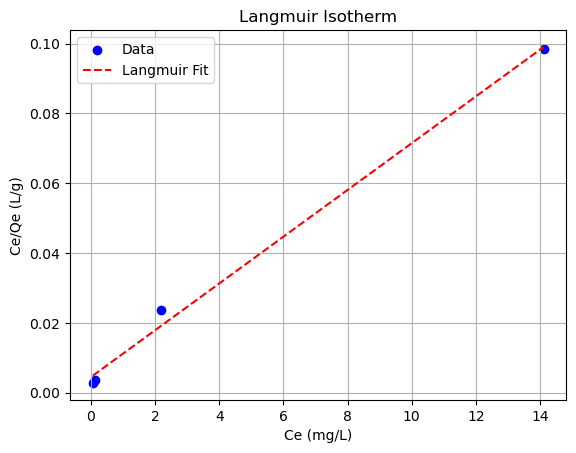

Freundlich: KF = 64.00 mg/g, n = 2.94, R² = 0.962


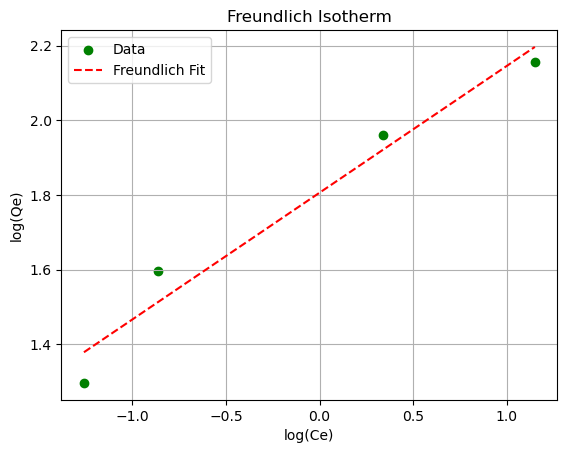

Temkin: b = 111.91 J/mol, AT = 42.171 L/mg, R² = 0.992


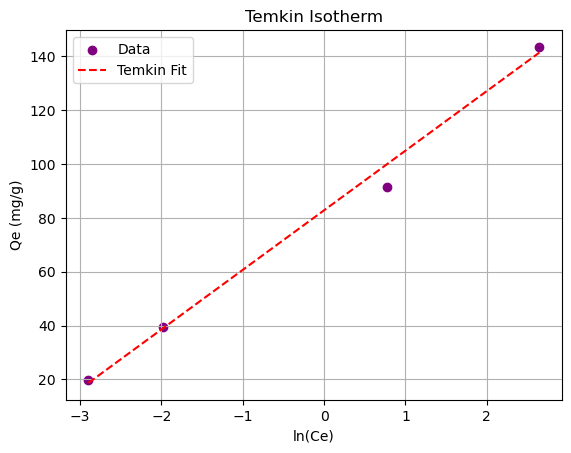

D-R: Qm = 112.90 mg/g, beta = 3.38e-08 mol²/J², E = 3.84 kJ/mol, R² = 0.952


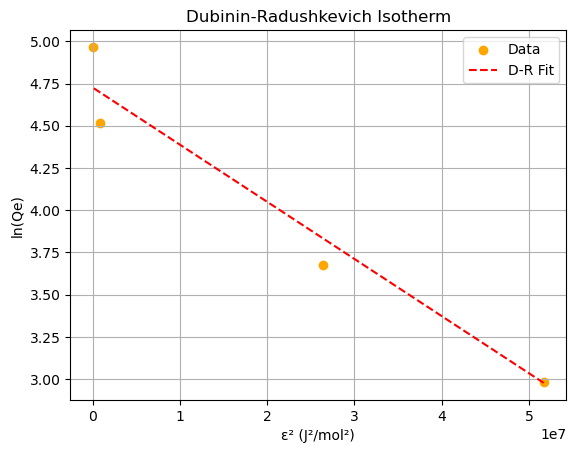

In [7]:
# ================================================================
# Usage for diff materials
# ================================================================

# Fit and visualize Langmuir model
print("MSN-COOH")
Qm, KL, R2_langmuir = langmuir_fit(Ce_c, Qe_c)
print(f"Langmuir: Qm = {Qm:.2f} mg/g, KL = {KL:.3f} L/mg, R² = {R2_langmuir:.3f}")
langmuir_plot(Ce_c, Qe_c, Qm, KL)

# Fit and visualize Freundlich model
KF, n, R2_freundlich = freundlich_fit(Ce_c, Qe_c)
print(f"Freundlich: KF = {KF:.2f} mg/g, n = {n:.2f}, R² = {R2_freundlich:.3f}")
freundlich_plot(Ce_c, Qe_c, KF, n)

# Fit and visualize Temkin model
b, AT, R2_temkin = temkin_fit(Ce_c, Qe_c)
print(f"Temkin: b = {b:.2f} J/mol, AT = {AT:.3f} L/mg, R² = {R2_temkin:.3f}")
temkin_plot(Ce_c, Qe_c, b, AT)

# Fit and visualize D–R model
Qm_dr, beta, E, R2_dr = dr_fit(Ce_c, Qe_c)
print(f"D-R: Qm = {Qm_dr:.2f} mg/g, beta = {beta:.2e} mol²/J², E = {E:.2f} kJ/mol, R² = {R2_dr:.3f}")
dr_plot(Ce_c, Qe_c, Qm_dr, beta)

# MSN-SH

MSN-SH
Langmuir: Qm = 129.19 mg/g, KL = 1.224 L/mg, R² = 0.998


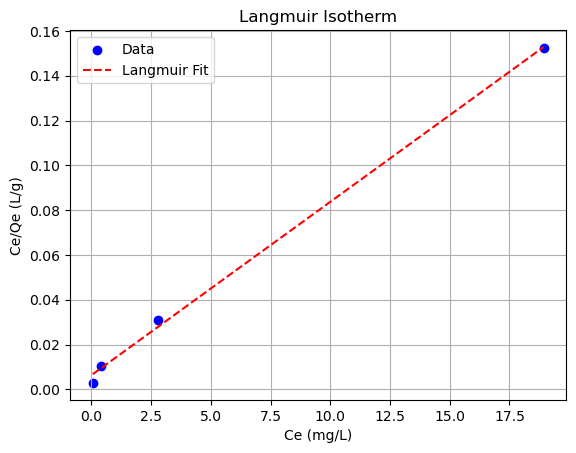

Freundlich: KF = 53.07 mg/g, n = 3.05, R² = 0.977


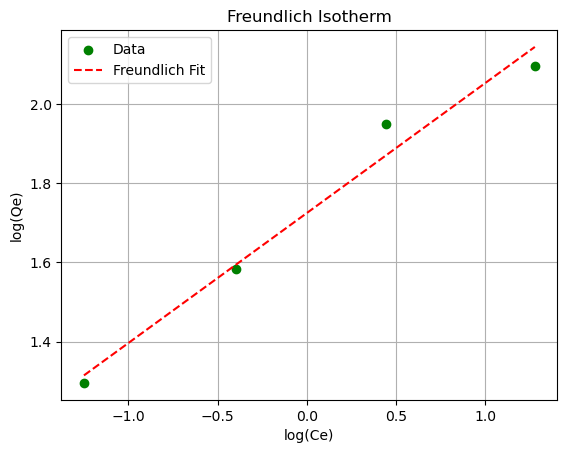

Temkin: b = 129.84 J/mol, AT = 35.622 L/mg, R² = 0.972


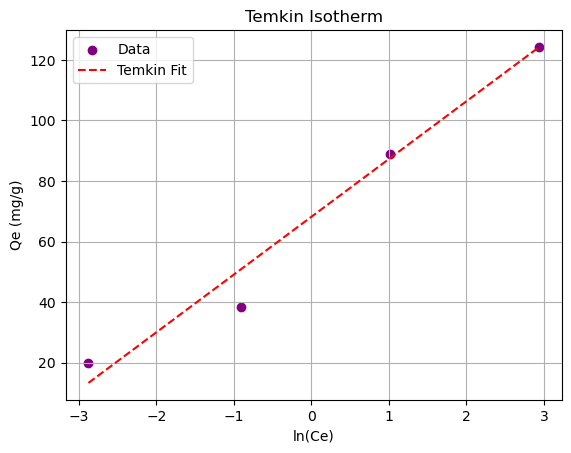

D-R: Qm = 85.71 mg/g, beta = 2.96e-08 mol²/J², E = 4.11 kJ/mol, R² = 0.797


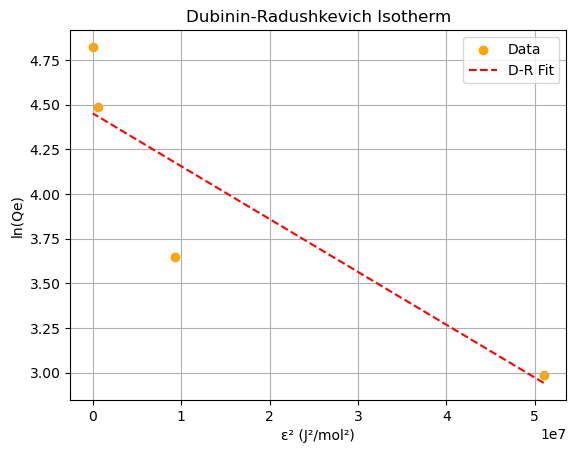

In [9]:
# ================================================================
# MSN-SH
# ================================================================

# Fit and visualize Langmuir model
print("MSN-SH")
Qm, KL, R2_langmuir = langmuir_fit(Ce_s, Qe_s)
print(f"Langmuir: Qm = {Qm:.2f} mg/g, KL = {KL:.3f} L/mg, R² = {R2_langmuir:.3f}")
langmuir_plot(Ce_s, Qe_s, Qm, KL)

# Fit and visualize Freundlich model
KF, n, R2_freundlich = freundlich_fit(Ce_s, Qe_s)
print(f"Freundlich: KF = {KF:.2f} mg/g, n = {n:.2f}, R² = {R2_freundlich:.3f}")
freundlich_plot(Ce_s, Qe_s, KF, n)

# Fit and visualize Temkin model
b, AT, R2_temkin = temkin_fit(Ce_s, Qe_s)
print(f"Temkin: b = {b:.2f} J/mol, AT = {AT:.3f} L/mg, R² = {R2_temkin:.3f}")
temkin_plot(Ce_s, Qe_s, b, AT)

# Fit and visualize D–R model
Qm_dr, beta, E, R2_dr = dr_fit(Ce_s, Qe_s)
print(f"D-R: Qm = {Qm_dr:.2f} mg/g, beta = {beta:.2e} mol²/J², E = {E:.2f} kJ/mol, R² = {R2_dr:.3f}")
dr_plot(Ce_s, Qe_s, Qm_dr, beta)

# MSN

bare MSN
Langmuir: Qm = 117.02 mg/g, KL = 0.864 L/mg, R² = 0.995


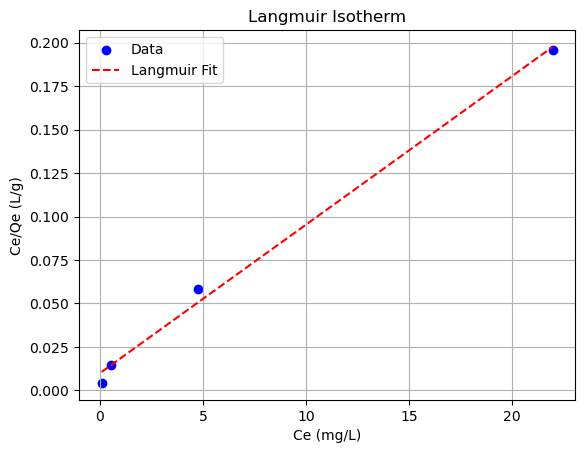

Freundlich: KF = 44.99 mg/g, n = 3.14, R² = 0.992


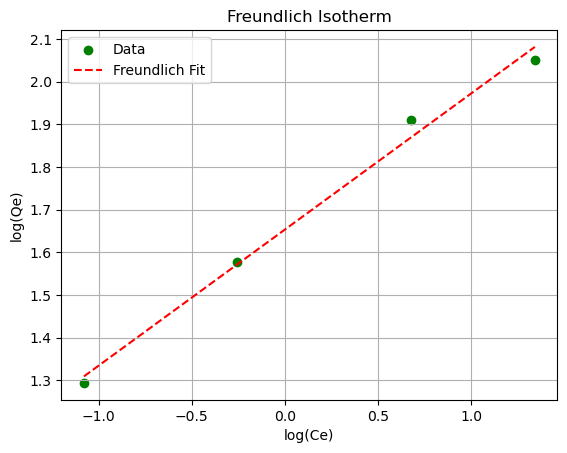

Temkin: b = 143.70 J/mol, AT = 27.242 L/mg, R² = 0.978


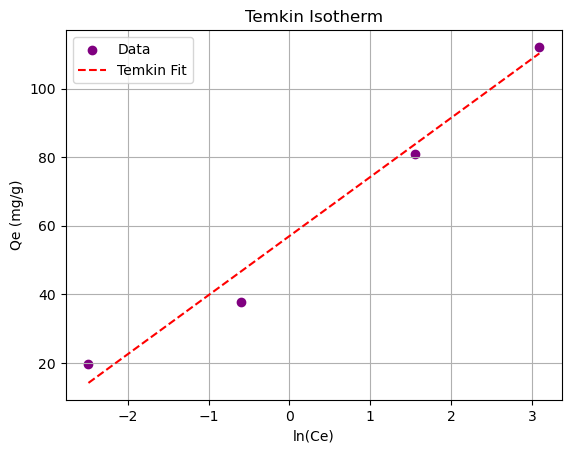

D-R: Qm = 78.02 mg/g, beta = 3.61e-08 mol²/J², E = 3.72 kJ/mol, R² = 0.793


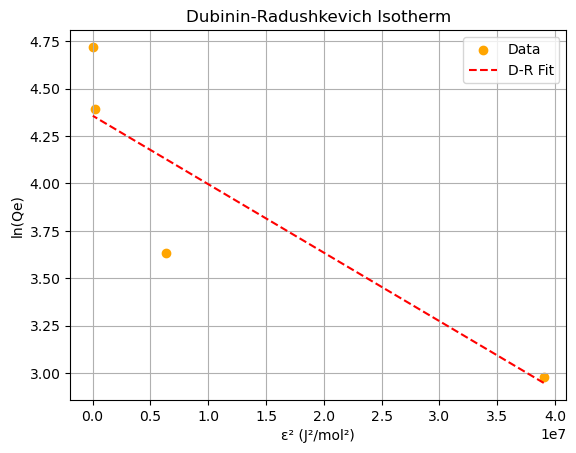

In [8]:
# ================================================================
# Usage for MSN bare
# ================================================================

# Fit and visualize Langmuir model
print("bare MSN")
Qm, KL, R2_langmuir = langmuir_fit(Ce_n, Qe_n)
print(f"Langmuir: Qm = {Qm:.2f} mg/g, KL = {KL:.3f} L/mg, R² = {R2_langmuir:.3f}")
langmuir_plot(Ce_n, Qe_n, Qm, KL)

# Fit and visualize Freundlich model
KF, n, R2_freundlich = freundlich_fit(Ce_n, Qe_n)
print(f"Freundlich: KF = {KF:.2f} mg/g, n = {n:.2f}, R² = {R2_freundlich:.3f}")
freundlich_plot(Ce_n, Qe_n, KF, n)

# Fit and visualize Temkin model
b, AT, R2_temkin = temkin_fit(Ce_n, Qe_n)
print(f"Temkin: b = {b:.2f} J/mol, AT = {AT:.3f} L/mg, R² = {R2_temkin:.3f}")
temkin_plot(Ce_n, Qe_n, b, AT)

# Fit and visualize D–R model
Qm_dr, beta, E, R2_dr = dr_fit(Ce_n, Qe_n)
print(f"D-R: Qm = {Qm_dr:.2f} mg/g, beta = {beta:.2e} mol²/J², E = {E:.2f} kJ/mol, R² = {R2_dr:.3f}")
dr_plot(Ce_n, Qe_n, Qm_dr, beta)

### That's the end for isotherm modelling of crystal violet (CV) dye adsorption

# Methyl orange dye begins here ...

### Let's start with data imports and renaming to ease working with it

In [11]:
isotherm_mo = pd.read_csv('isotherm_MO_data.csv', index_col=None)

isotherm_mo.head(3)

,Ce_COOH,Qe_COOH,Ce_SH,Qe_SH,Ce_MSN,Qe_MSN
0,0.518250,0.963500,0.539155,0.921691,0.894528,0.210944
1,3.490494,3.019012,4.417859,1.164283,4.957849,0.084302
2,7.911090,4.177820,8.468672,3.062657,9.945165,0.109669


In [12]:
Ce_c_m = isotherm_mo.Ce_COOH #Ce of MSN-COOH
Ce_s_m = isotherm_mo.Ce_SH #Ce of MSN-SH
Ce_n_m = isotherm_mo.Ce_MSN #Ce of MSN

Qe_c_m = isotherm_mo.Qe_COOH #qe of MSN-COOH
Qe_s_m = isotherm_mo.Qe_SH #qe of MSN-SH
Qe_n_m = isotherm_mo.Qe_MSN #qe of MSN

## MSN-COOH in methyl orange dye

MSN-COOH
Langmuir: Qm = 10.69 mg/g, KL = 0.117 L/mg, R² = 0.981


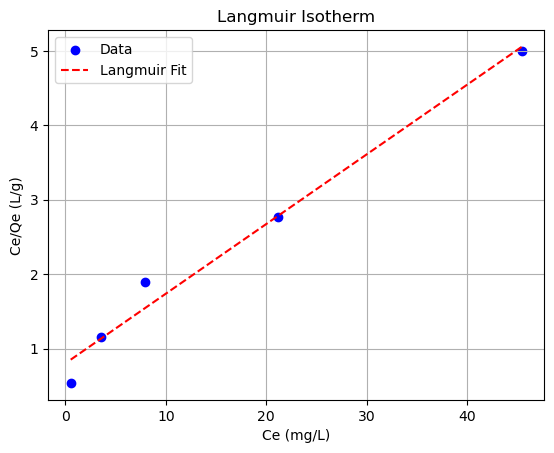

Freundlich: KF = 1.45 mg/g, n = 1.95, R² = 0.988


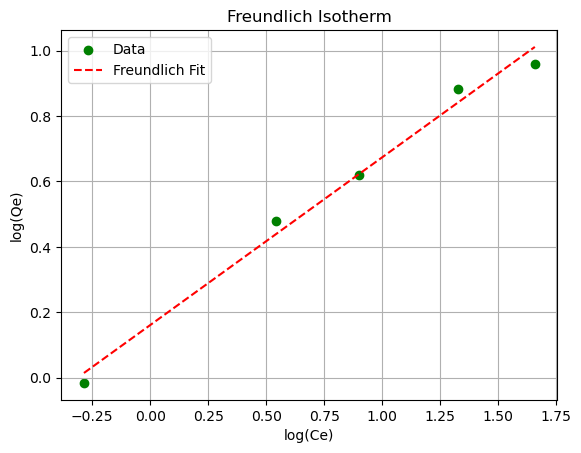

Temkin: b = 1306.10 J/mol, AT = 2.147 L/mg, R² = 0.934


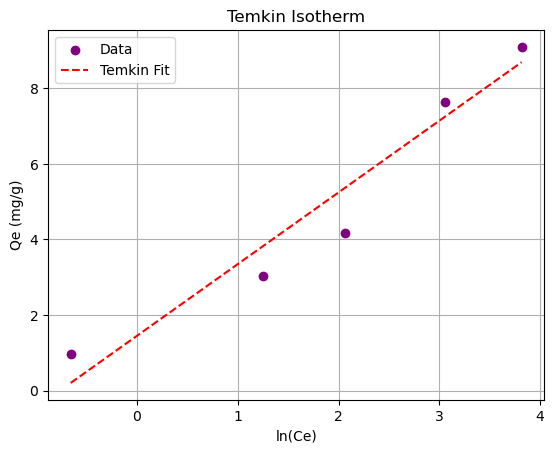

D-R: Qm = 5.66 mg/g, beta = 2.54e-07 mol²/J², E = 1.40 kJ/mol, R² = 0.788


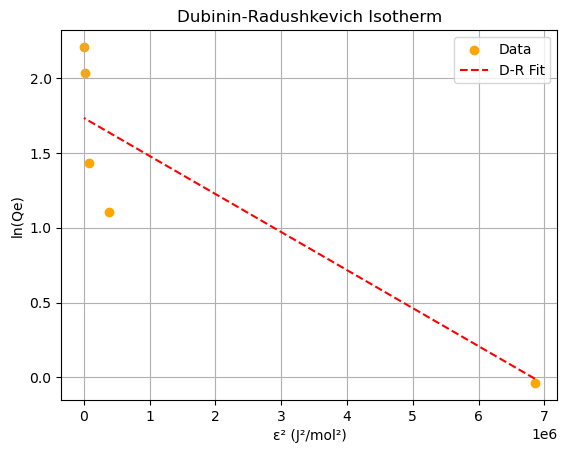

In [13]:
# Fit and visualize Langmuir model
print("MSN-COOH")
Qm, KL, R2_langmuir = langmuir_fit(Ce_c_m, Qe_c_m)
print(f"Langmuir: Qm = {Qm:.2f} mg/g, KL = {KL:.3f} L/mg, R² = {R2_langmuir:.3f}")
langmuir_plot(Ce_c_m, Qe_c_m, Qm, KL)

# Fit and visualize Freundlich model
KF, n, R2_freundlich = freundlich_fit(Ce_c_m, Qe_c_m)
print(f"Freundlich: KF = {KF:.2f} mg/g, n = {n:.2f}, R² = {R2_freundlich:.3f}")
freundlich_plot(Ce_c_m, Qe_c_m, KF, n)

# Fit and visualize Temkin model
b, AT, R2_temkin = temkin_fit(Ce_c_m, Qe_c_m)
print(f"Temkin: b = {b:.2f} J/mol, AT = {AT:.3f} L/mg, R² = {R2_temkin:.3f}")
temkin_plot(Ce_c_m, Qe_c_m, b, AT)

# Fit and visualize D–R model
Qm_dr, beta, E, R2_dr = dr_fit(Ce_c_m, Qe_c_m)
print(f"D-R: Qm = {Qm_dr:.2f} mg/g, beta = {beta:.2e} mol²/J², E = {E:.2f} kJ/mol, R² = {R2_dr:.3f}")
dr_plot(Ce_c_m, Qe_c_m, Qm_dr, beta)

## MSN-SH methyl orange

MSN-SH MO-dye
Langmuir: Qm = 6.87 mg/g, KL = 0.076 L/mg, R² = 0.855


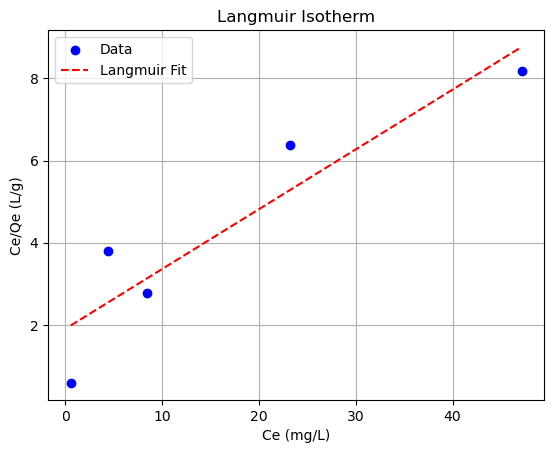

Freundlich: KF = 1.00 mg/g, n = 2.37, R² = 0.868


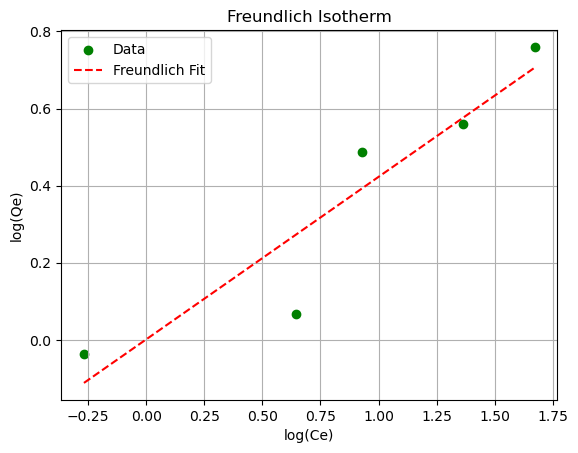

Temkin: b = 2368.04 J/mol, AT = 2.283 L/mg, R² = 0.804


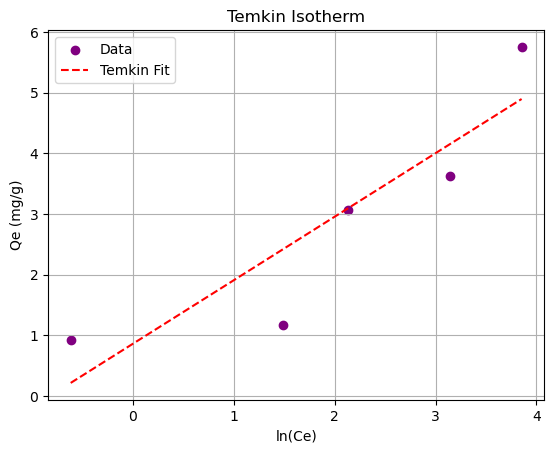

D-R: Qm = 3.01 mg/g, beta = 1.80e-07 mol²/J², E = 1.67 kJ/mol, R² = 0.475


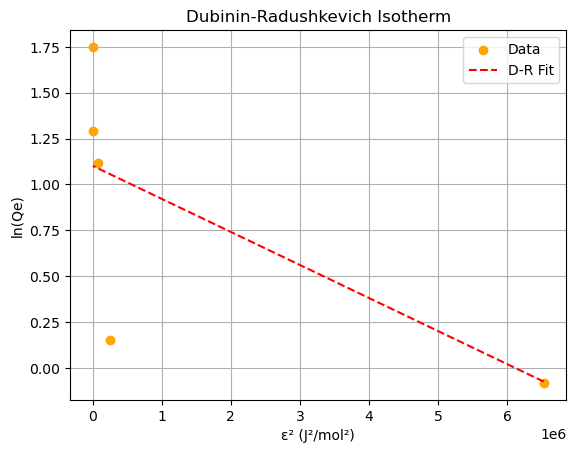

In [14]:
# Fit and visualize Langmuir model
print("MSN-SH MO-dye")
Qm, KL, R2_langmuir = langmuir_fit(Ce_s_m, Qe_s_m)
print(f"Langmuir: Qm = {Qm:.2f} mg/g, KL = {KL:.3f} L/mg, R² = {R2_langmuir:.3f}")
langmuir_plot(Ce_s_m, Qe_s_m, Qm, KL)

# Fit and visualize Freundlich model
KF, n, R2_freundlich = freundlich_fit(Ce_s_m, Qe_s_m)
print(f"Freundlich: KF = {KF:.2f} mg/g, n = {n:.2f}, R² = {R2_freundlich:.3f}")
freundlich_plot(Ce_s_m, Qe_s_m, KF, n)

# Fit and visualize Temkin model
b, AT, R2_temkin = temkin_fit(Ce_s_m, Qe_s_m)
print(f"Temkin: b = {b:.2f} J/mol, AT = {AT:.3f} L/mg, R² = {R2_temkin:.3f}")
temkin_plot(Ce_s_m, Qe_s_m, b, AT)

# Fit and visualize D–R model
Qm_dr, beta, E, R2_dr = dr_fit(Ce_s_m, Qe_s_m)
print(f"D-R: Qm = {Qm_dr:.2f} mg/g, beta = {beta:.2e} mol²/J², E = {E:.2f} kJ/mol, R² = {R2_dr:.3f}")
dr_plot(Ce_s_m, Qe_s_m, Qm_dr, beta)

## MSN for methyl orange

MSN-COOH
Langmuir: Qm = 0.69 mg/g, KL = 0.030 L/mg, R² = 0.383


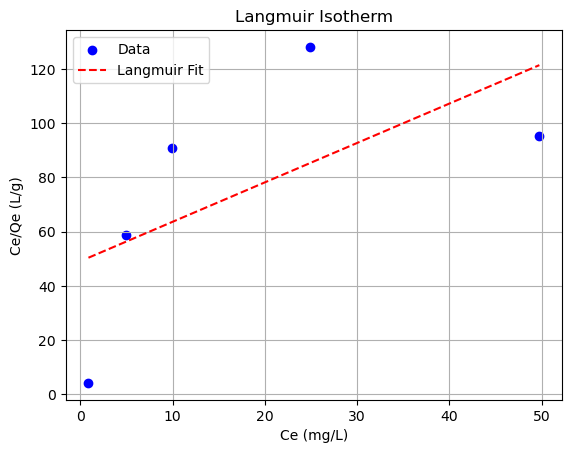

Freundlich: KF = 0.12 mg/g, n = 4.98, R² = 0.196


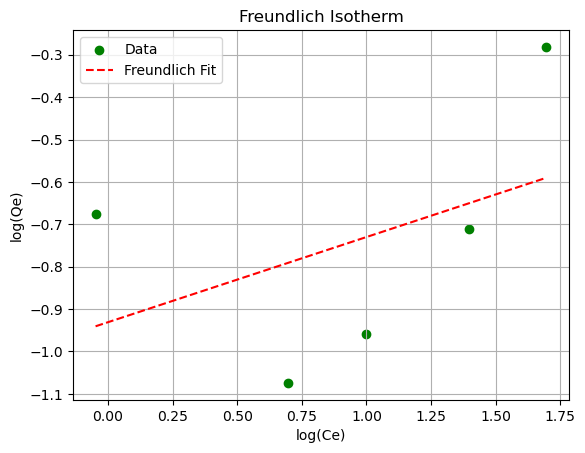

Temkin: b = 40344.00 J/mol, AT = 4.643 L/mg, R² = 0.286


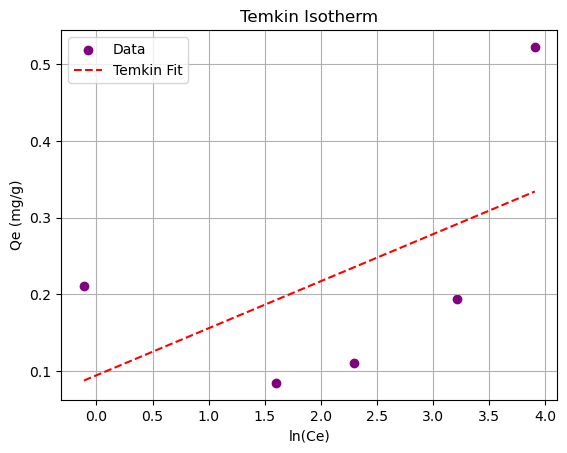

C:\Users\Admin\AppData\Local\Temp\ipykernel_12820\4089955779.py:121: RuntimeWarning: invalid value encountered in sqrt
  E = 1 / np.sqrt(2 * beta) / 1000  # Convert to kJ/mol


D-R: Qm = 0.18 mg/g, beta = -3.59e-08 mol²/J², E = nan kJ/mol, R² = 0.006


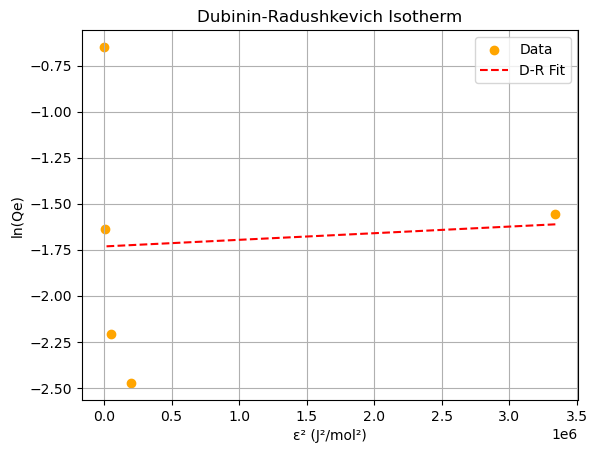

In [15]:
# Fit and visualize Langmuir model
print("MSN-COOH")
Qm, KL, R2_langmuir = langmuir_fit(Ce_n_m, Qe_n_m)
print(f"Langmuir: Qm = {Qm:.2f} mg/g, KL = {KL:.3f} L/mg, R² = {R2_langmuir:.3f}")
langmuir_plot(Ce_n_m, Qe_n_m, Qm, KL)

# Fit and visualize Freundlich model
KF, n, R2_freundlich = freundlich_fit(Ce_n_m, Qe_n_m)
print(f"Freundlich: KF = {KF:.2f} mg/g, n = {n:.2f}, R² = {R2_freundlich:.3f}")
freundlich_plot(Ce_n_m, Qe_n_m, KF, n)

# Fit and visualize Temkin model
b, AT, R2_temkin = temkin_fit(Ce_n_m, Qe_n_m)
print(f"Temkin: b = {b:.2f} J/mol, AT = {AT:.3f} L/mg, R² = {R2_temkin:.3f}")
temkin_plot(Ce_n_m, Qe_n_m, b, AT)

# Fit and visualize D–R model
Qm_dr, beta, E, R2_dr = dr_fit(Ce_n_m, Qe_n_m)
print(f"D-R: Qm = {Qm_dr:.2f} mg/g, beta = {beta:.2e} mol²/J², E = {E:.2f} kJ/mol, R² = {R2_dr:.3f}")
dr_plot(Ce_n_m, Qe_n_m, Qm_dr, beta)